In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from keras import backend as K

from keras.models import Model
from keras import metrics
from keras.losses import mse
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Latent Diffusion Models

It is diffusion process in the latent space. 

1. This works by using a trained Encoder E for encoding a full-size image to a lower dimension representation (latent space). 

2. Then making the forward diffusion process and the reverse diffusion process within the latent space.

3. Later on, with a trained Decoder D, we can decode the image from its latent representation back to the pixel-space. 

For constructing the encoder and decoder, we can train some variant of a Variational AutoEncoder (VAE). This network is then decoupled for using both components separately.

Shifting diffusion operations to the latent space in Stable Diffusion enhances speed and reduces costs. This advancement accelerates denoising and sampling processes, making it an efficient solution for high-quality image generation and stable training.

By leveraging the latent space, Stable Diffusion eases the computational burden in the reverse diffusion process. This enables quicker denoising of images, enhancing both speed and overall model stability and robustness.

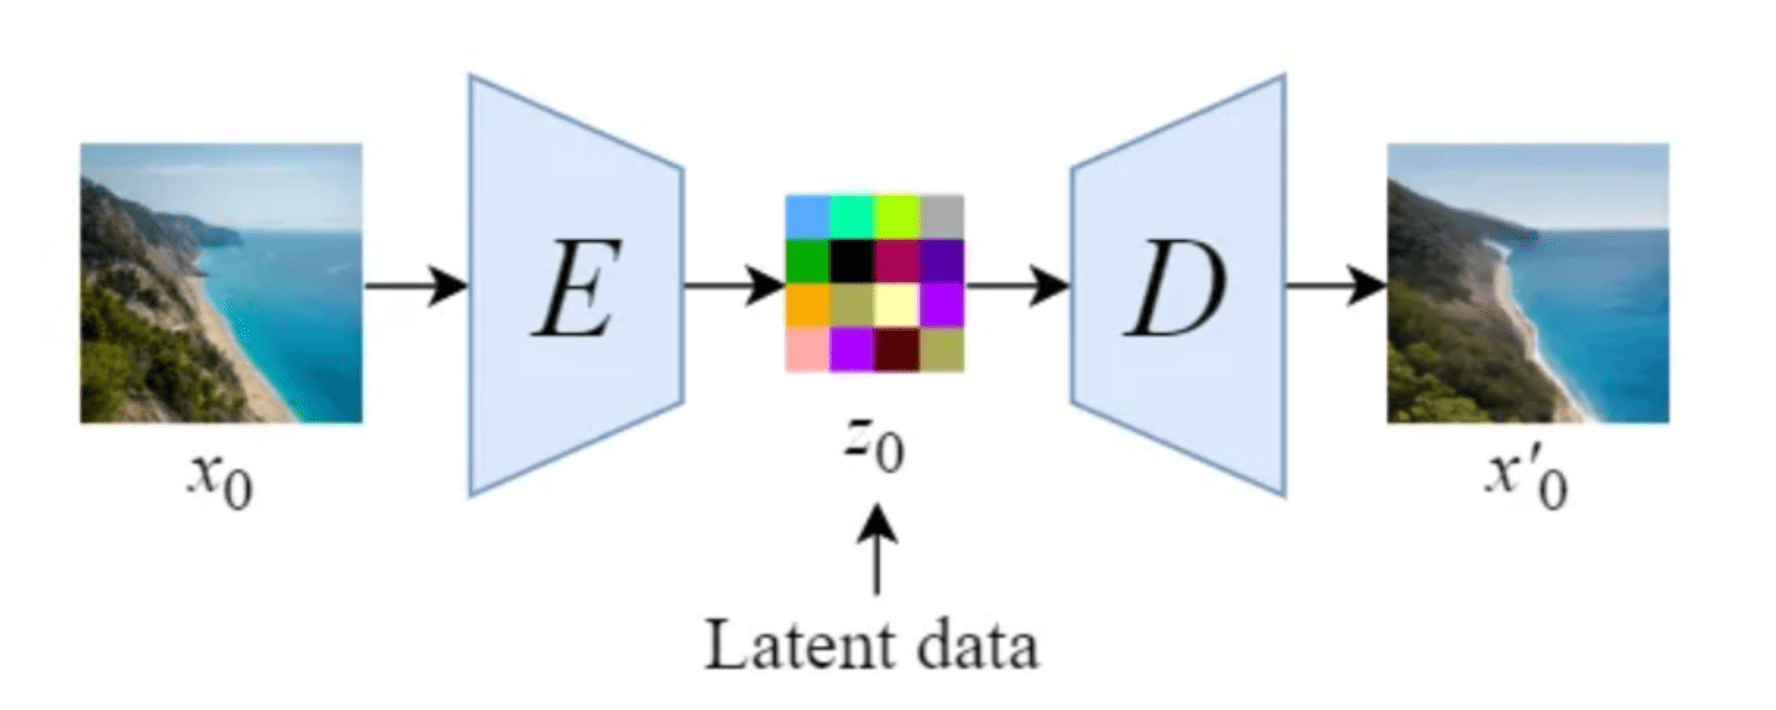

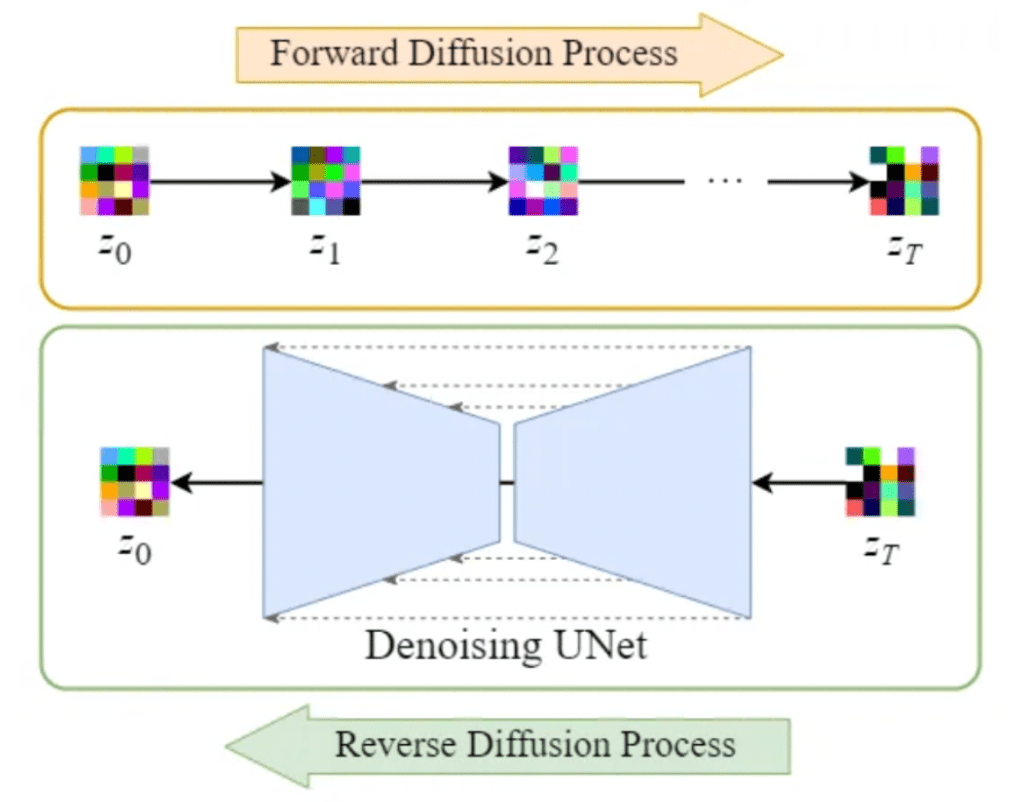

# Load Data

In [2]:
base_dir = 'apple/'

# List to store image arrays
hr_img = []

# Loop through each folder (person) in the base directory
for person in os.listdir(base_dir):

    person_dir = os.path.join(base_dir, person)

    try:

        # Read the image using OpenCV
        img = cv2.imread(person_dir)

        # Convert the image to RGB (OpenCV uses BGR by default)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb = img_rgb/255
        hr = cv2.resize(img_rgb,(128,128))

        # Append the image array to the list
        hr_img.append(hr)
        
    except:
        pass
            
hr_img = tf.convert_to_tensor(hr_img)
len(hr_img)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
2024-05-04 17:50:23.110439: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-04 17:50:23.110459: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-05-04 17:50:23.110462: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-05-04 17:50:23.110493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-04 17:50:23.110506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


70

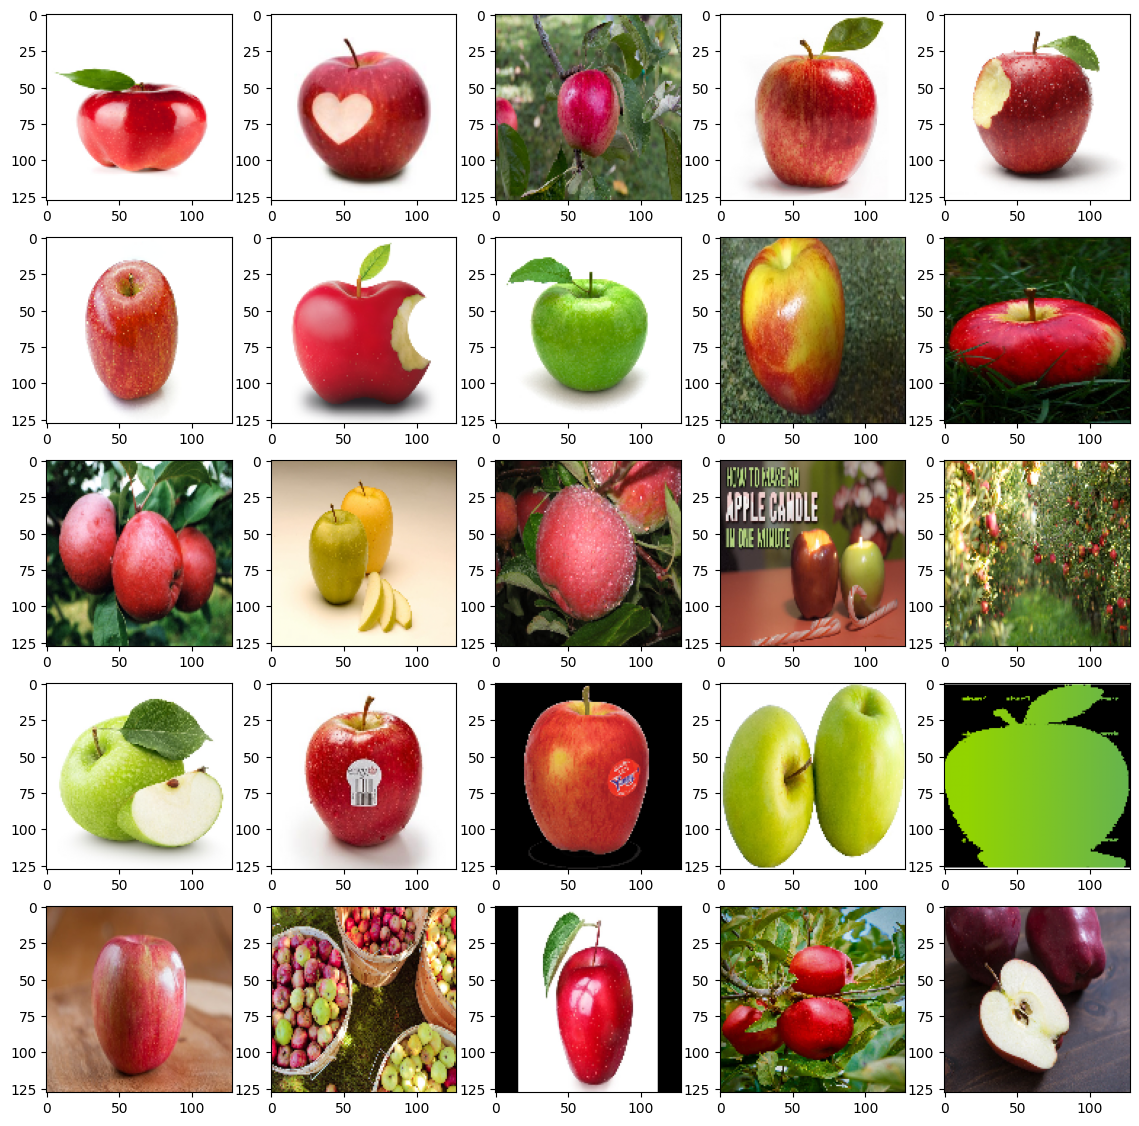

In [3]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = [image for image in hr_img]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

# Variantional Auto Encoder

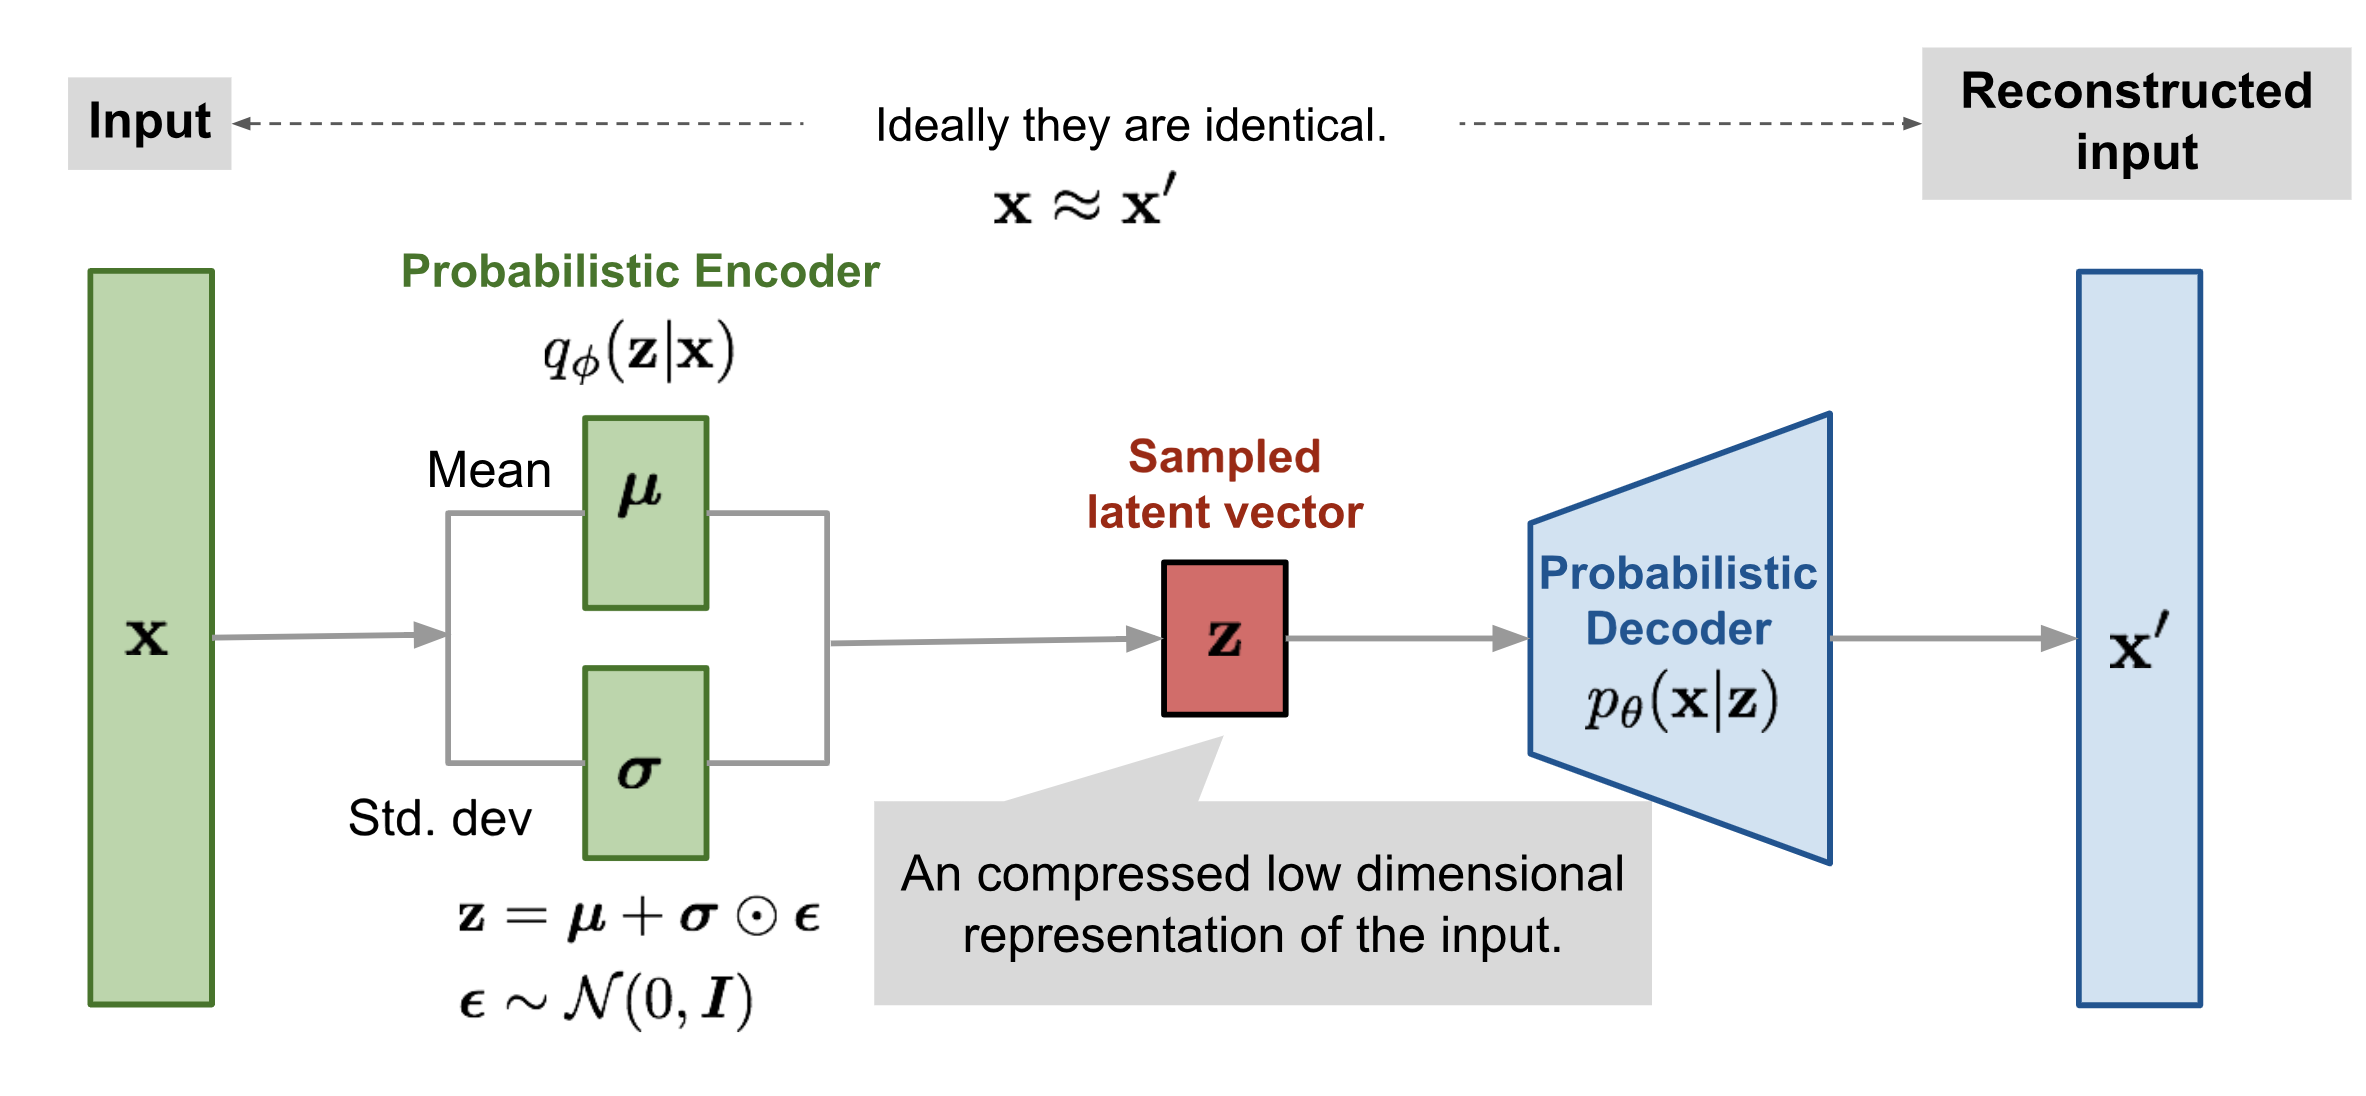

In [4]:
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

# Encoder network
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', strides=(2, 2),padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', strides=(2, 2),padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

z_mean, z_log_var = tf.split(x, 2, axis=-1)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0., stddev=0.01)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])
z

<KerasTensor: shape=(None, 16, 16, 4) dtype=float32 (created by layer 'lambda')>

In [5]:
# Decoder network
decoder_input = layers.Input(shape=(16, 16, 4)) 

x = Conv2DTranspose(256, (2, 2), activation='relu', padding='same', strides=(2, 2))(decoder_input)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2D(3, (2, 2), activation='sigmoid', padding='same',strides=(2, 2))(x)
x

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'conv2d_5')>

In [6]:
from keras.models import Model

# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Loss Functions

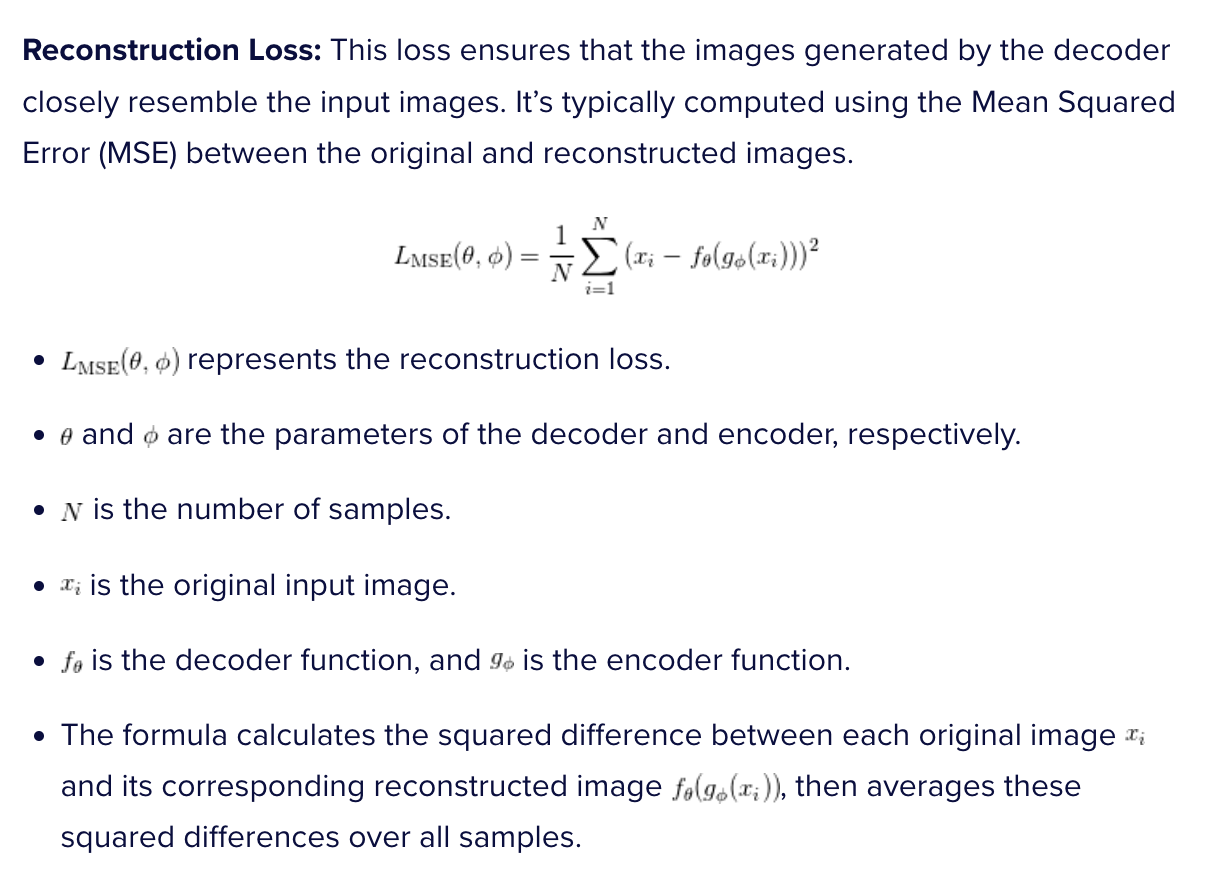

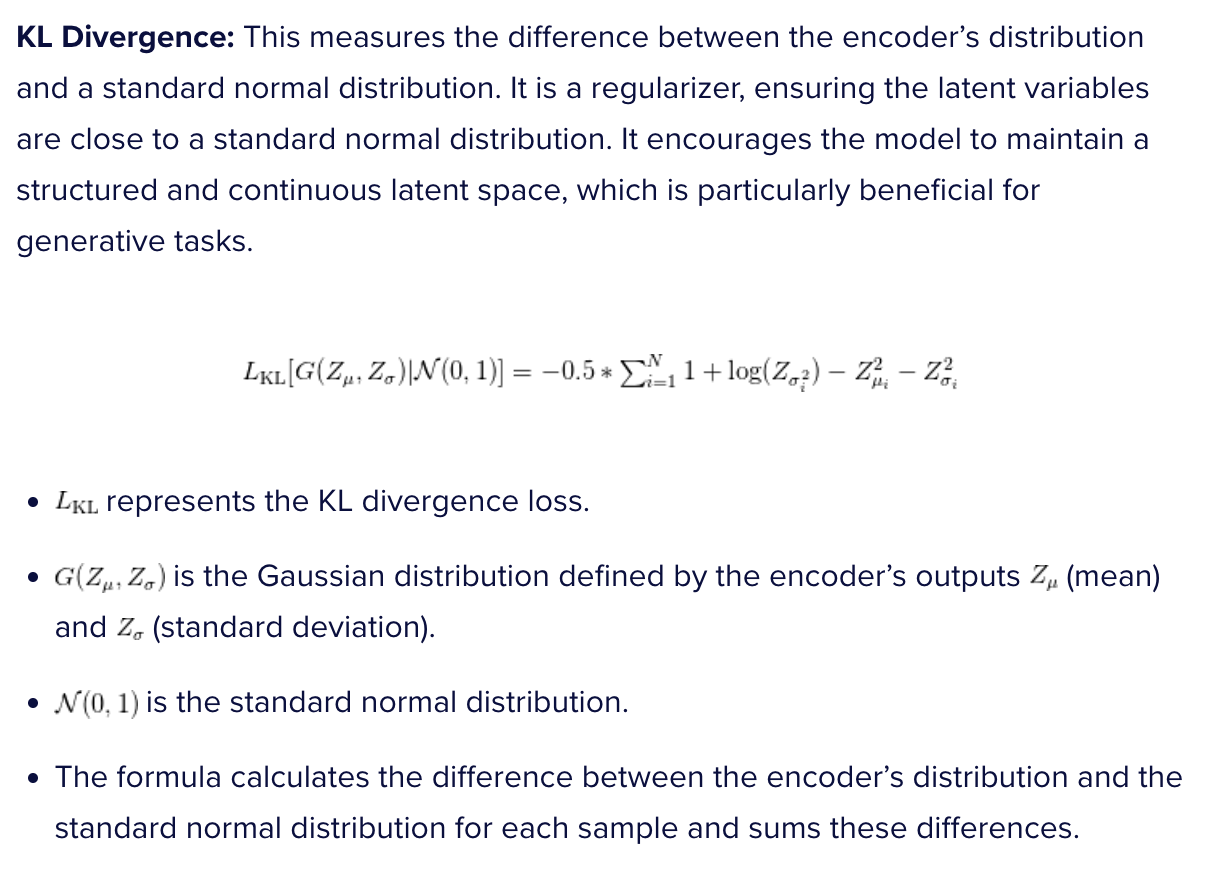

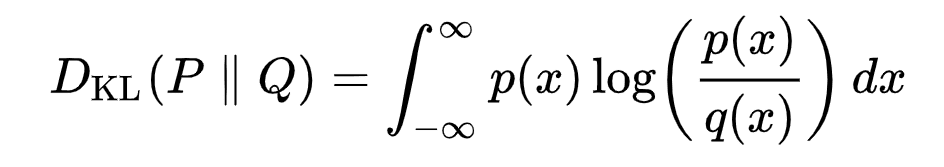

In [7]:
# Define the VAE loss function

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
kl_loss = tf.reduce_mean(tf.reduce_sum(loss, axis=1))

B = 1000   
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")
vae.compile(optimizer='adam')

In [ ]:
vae.fit(hr_img,hr_img, epochs=200)

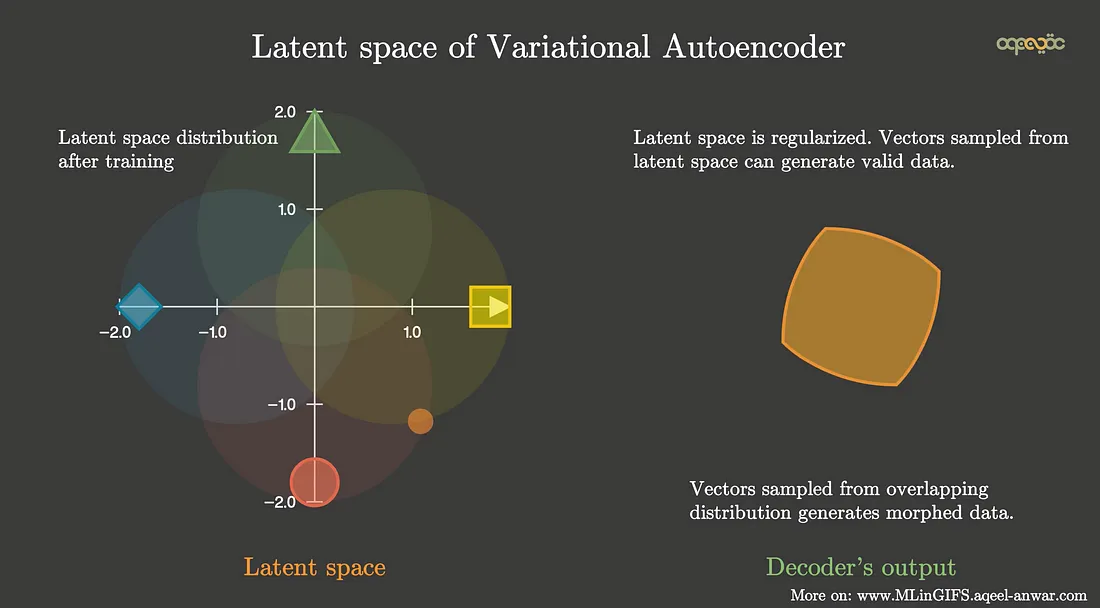

2/3 [===================>..........] - ETA: 0s

2024-05-04 17:53:50.724632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 110ms/step


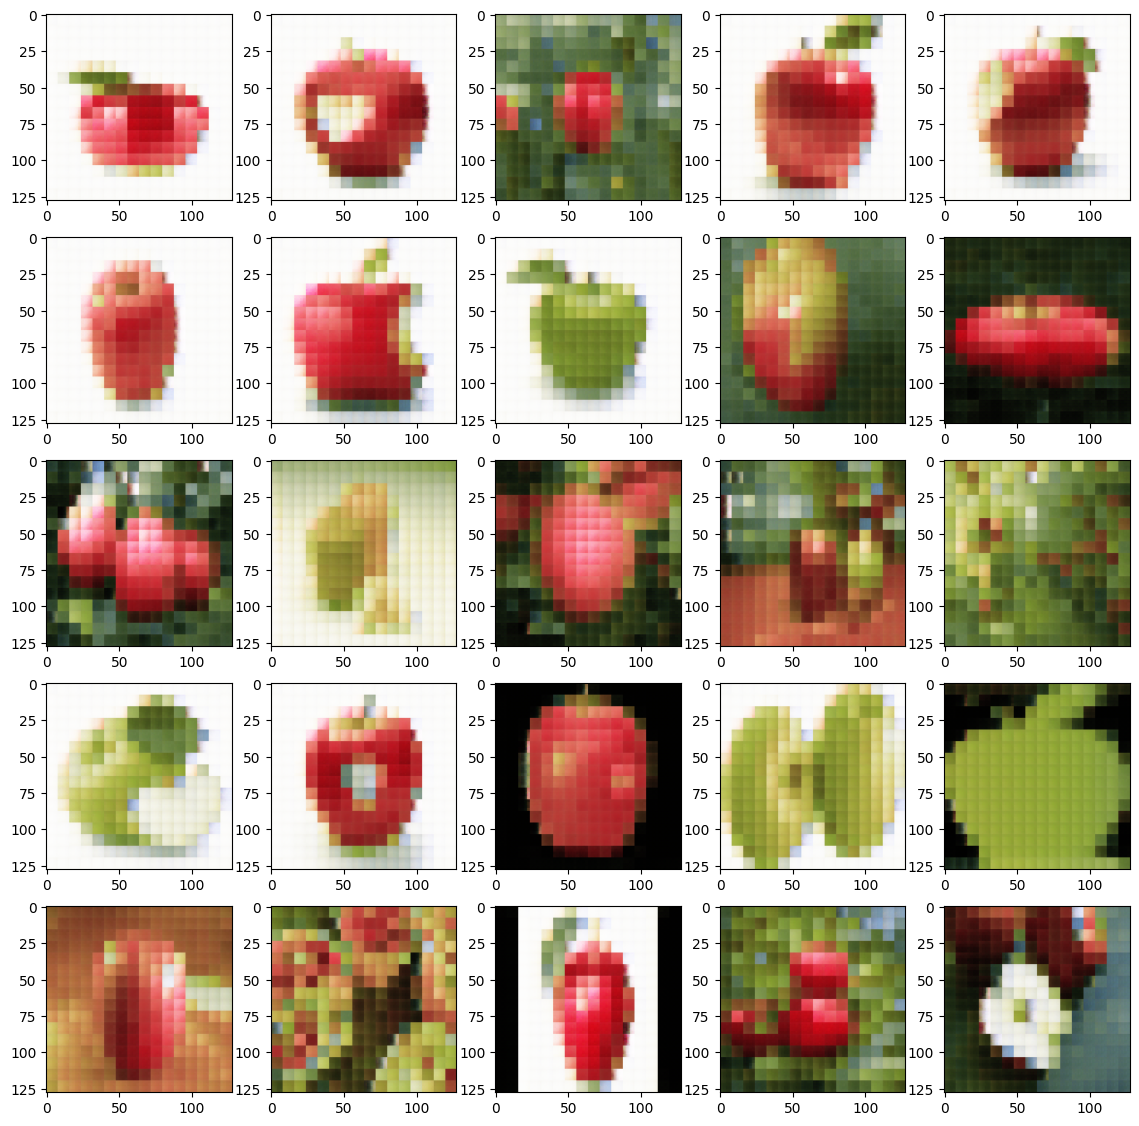

In [11]:
k = vae.predict(hr_img)

# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = [image for image in k]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [12]:
vae.save(f'model_vae_checkpoint.h5_vae')
encoder.save(f'model_vae_checkpoint.h5_encoder')
decoder.save(f'model_vae_checkpoint.h5_decoder')

INFO:tensorflow:Assets written to: model_vae_checkpoint.h5_vae/assets


INFO:tensorflow:Assets written to: model_vae_checkpoint.h5_vae/assets


INFO:tensorflow:Assets written to: model_vae_checkpoint.h5_encoder/assets


INFO:tensorflow:Assets written to: model_vae_checkpoint.h5_encoder/assets


INFO:tensorflow:Assets written to: model_vae_checkpoint.h5_decoder/assets


INFO:tensorflow:Assets written to: model_vae_checkpoint.h5_decoder/assets


# Get the latent vector from the trained VAE model

In [13]:
mu, log_var, z = encoder.predict(hr_img)

3/3 [==============================] - 0s 23ms/step


2024-05-04 17:53:53.612306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Define the add noise function for forward diffusion process

In [14]:
timesteps = 100

# create a fixed beta schedule
beta = np.linspace(0.01, 0.2, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)


def add_noise(x_0, t):
    noise = np.random.normal(size=x_0.shape)
    sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), [-1, 1, 1, 1])
    one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), [-1, 1, 1, 1])
    noisy_img = sqrt_alpha_bar_t  * x_0 + one_minus_sqrt_alpha_bar_t  * noise
    return noisy_img, noise


# define the UNET model that takes input as noisy image and time step while it  outputs noise as prediction.

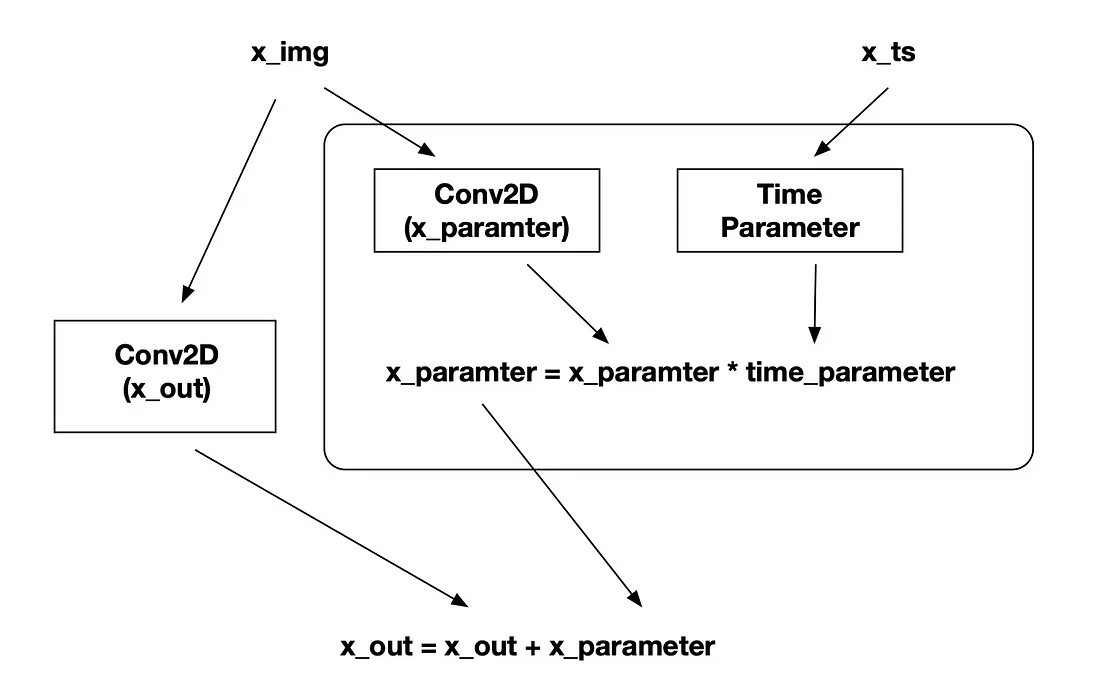

In [15]:
def block(x_img, x_ts):
    
    x_parameter = layers.Conv2D(64, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(64)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 64))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    # -----
    x_out = layers.Conv2D(64, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

def make_model():
    x = x_input = layers.Input(shape=(16,16, 4), name='x_input')
    
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(64)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(64)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4*4*64)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4,4,64))(x)
    
    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    # ----- output -----
    x = layers.Conv2D(4, kernel_size=1, padding='same')(x)
    
    return tf.keras.models.Model([x_input, x_ts_input], x)

model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   128       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization (Layer  (None, 64)                   128       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64)                   0         ['layer_normalization[0][0

 tf.__operators__.add_4 (TF  (None, 4, 4, 64)             0         ['conv2d_11[0][0]',           
 OpLambda)                                                           'tf.math.multiply_5[0][0]']  
                                                                                                  
 layer_normalization_3 (Lay  (None, 4, 4, 64)             128       ['tf.__operators__.add_4[0][0]
 erNormalization)                                                   ']                            
                                                                                                  
 activation_9 (Activation)   (None, 4, 4, 64)             0         ['layer_normalization_3[0][0]'
                                                                    ]                             
                                                                                                  
 flatten (Flatten)           (None, 1024)                 0         ['activation_9[0][0]']        
          

 layer_normalization_7 (Lay  (None, 8, 8, 64)             128       ['tf.__operators__.add_6[0][0]
 erNormalization)                                                   ']                            
                                                                                                  
 activation_17 (Activation)  (None, 8, 8, 64)             0         ['layer_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 up_sampling2d_1 (UpSamplin  (None, 16, 16, 64)           0         ['activation_17[0][0]']       
 g2D)                                                                                             
                                                                                                  
 concatenate_3 (Concatenate  (None, 16, 16, 128)          0         ['up_sampling2d_1[0][0]',     
 )        

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.MeanSquaredError()
model.compile(loss=loss_func, optimizer=optimizer)

In [17]:
def ddim(x_t, pred_noise, t, step_size):
    alpha_t_bar = np.reshape(np.take(alpha_bar, t), [-1, 1, 1, 1])
    alpha_t_minus_one = np.reshape(np.take(alpha_bar, t-step_size), [-1, 1, 1, 1])
        
    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one) ** 0.5) * pred_noise
    return pred

inference_timesteps = 100
inference_range = range(0, timesteps, timesteps // inference_timesteps)
inf_step = timesteps // inference_timesteps

# Perform the diffusion process on the latent vector of the VAE

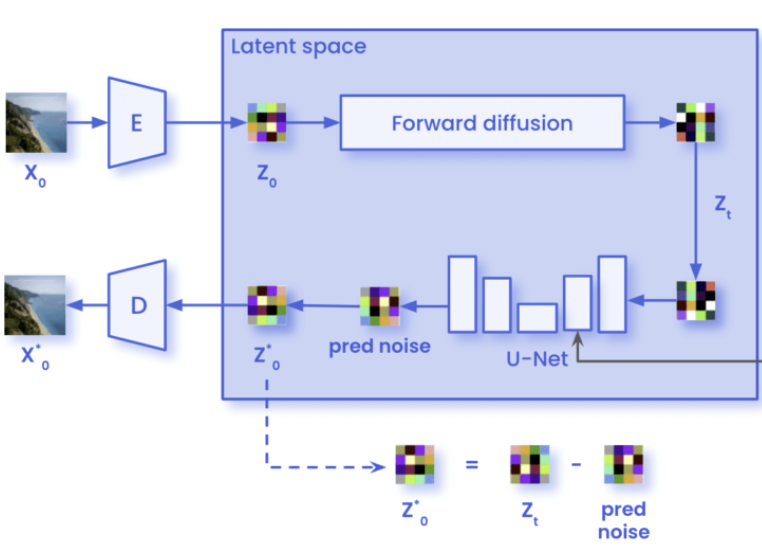

In [ ]:
t = np.arange(100,-1,-1)

for j in range(0,100,3):
    
    if j ==99:
        break

    noisy_img = []
    noise = []
    time = []

    for i in t[-100+j:-100+j+3]:
        print(i,j)
        img,nos = add_noise(z, i)
        noisy_img.append(img)
        noise.append(nos)
        time.append(np.repeat(i,len(img)))

    noisy_img = np.array(noisy_img).reshape((len(z)*3, 16,16,4))
    time = np.array(time).reshape((len(z)*3, 1))
    noise = np.array(noise).reshape((len(z)*3, 16,16,4))

    model.fit([noisy_img,time],noise,epochs=200)
    
    model.save(f'model_vae_checkpoint.h5_{100-j-3}')

# Load the trained model and make prediction

In [ ]:
from tensorflow.keras.models import load_model

x = tf.random.normal((16,16,16,4))

checkpoints = np.arange(1,100,3)

for index, i in enumerate(reversed(range(inference_timesteps))):
    t = np.repeat(inference_range[i], 16)
    
    if i >3:
        if (i - 2) in checkpoints:
            model = load_model(f'model_vae_checkpoint.h5_{i-2}')
            print('loaded model : ',i,i-2)
            
    if i ==3:
        model = load_model('model_vae_checkpoint.h5_1')
        print(i)
        
    if i<=2:
        pass
        
    pred_noise = model.predict([x, np.full((16),  t)], verbose=0)
    x = ddim(x, pred_noise, t, inf_step)
    
    if any(t-inf_step) == 0:
        break

1/1 [==============================] - 0s 71ms/step


2024-05-04 18:21:34.821324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


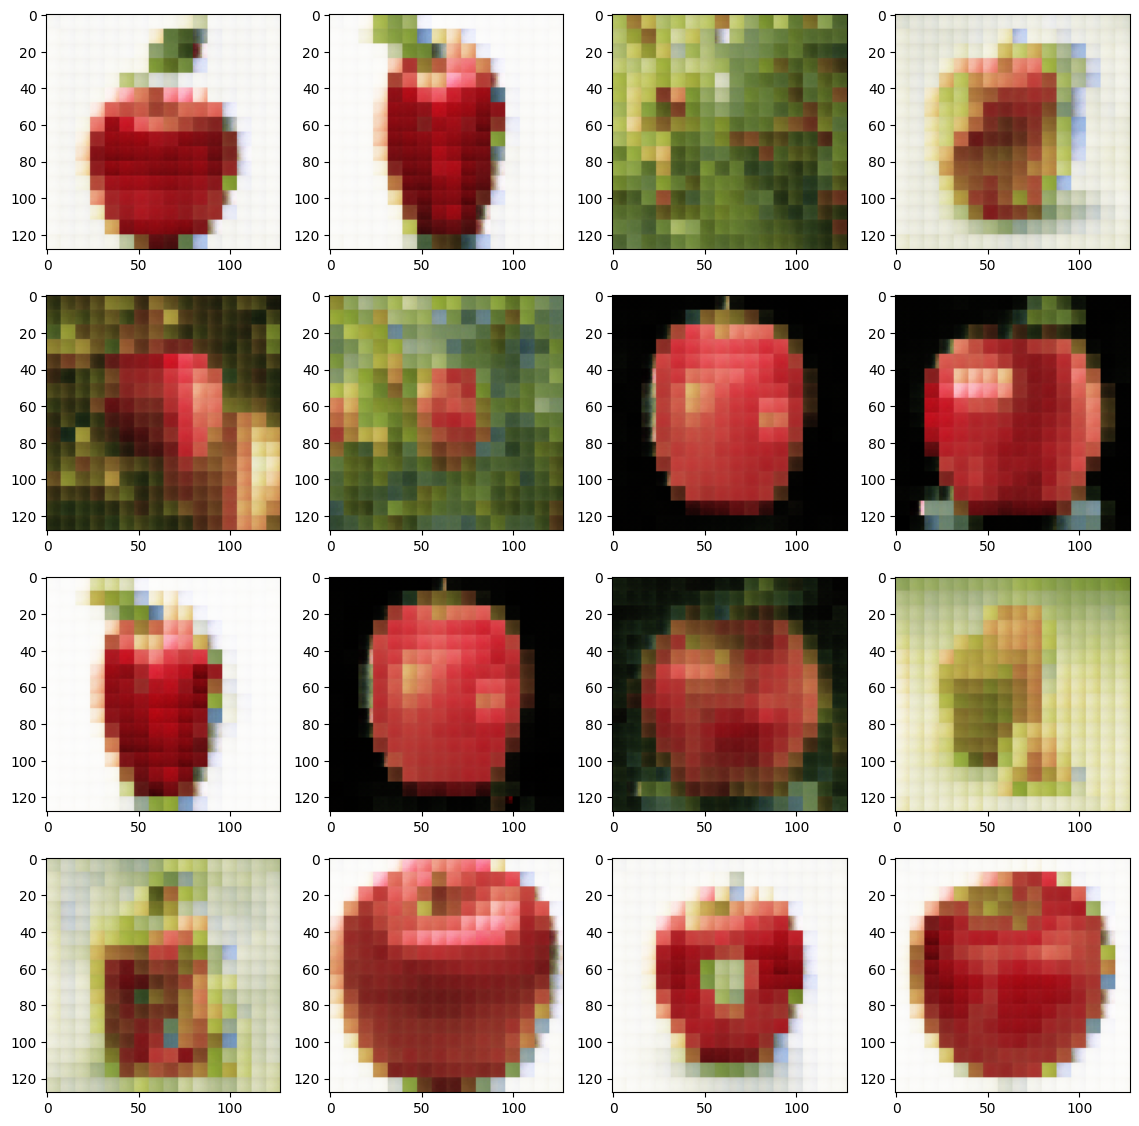

In [20]:
Output = decoder.predict(x)

# visualize some of them
fig, axes = plt.subplots(4,4, figsize = (14,14))

sample = [image for image in Output]

idx = 0
for row in range(4):
    for column in range(4):
        axes[row, column].imshow(sample[idx])
        idx+=1